### Imports, setting matplotlib output and chart style

In [44]:
%matplotlib inline
from sqlalchemy import create_engine, text
import json
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

# setting up a visual style for PyPlot, much better than the standard
plt.style.use('fivethirtyeight')

# Your database url as specified in configuration.yaml
# If using default settings, it's \
# sqlite:///<path to config dir>/home-assistant_v2.db
DB_URL = "sqlite:///./home-assistant_v2.db"
engine = create_engine(DB_URL)

### Basic query against the local database

In [57]:
# Let's query the states table of our database, get a list of entities \
# and number of statuses they've created
list(engine.execute("SELECT entity_id, COUNT(*) FROM states \
GROUP BY entity_id ORDER by 2 DESC"))

[('sun.sun', 9058),
 ('sensor.sr_temp', 5660),
 ('sensor.ucsd_luminance', 1456),
 ('sensor.ucsd_temperature', 928),
 ('sensor.ucsd_humidity', 639),
 ('sensor.ucsd_voltage', 598),
 ('sensor.aeotec_dsb05_multisensor_temperature_2', 448),
 ('device_tracker.paulus_nexus5x', 402),
 ('sensor.aeotec_dsb05_multisensor_luminance_2', 385),
 ('sensor.aeotec_dsb05_multisensor_relative_humidity_2', 354),
 ('device_tracker.anne_therese', 300),
 ('binary_sensor.aeotec_dsb05_multisensor_sensor_2', 285),
 ('group.other', 285),
 ('group.all_devices', 205),
 ('light.ceiling', 191),
 ('light.tv_back_light', 191),
 ('light.bowl', 160),
 ('sensor.ucsd_uvindex', 158),
 ('sensor.ucsd_pressure', 127),
 ('media_player.my_nexus_player', 46),
 ('group.all_lights', 43),
 ('sensor.lr_temp', 43),
 ('sensor.lr_hum', 41),
 ('group.living_room', 39),
 ('sensor.sr_hum', 38),
 ('group.default_view', 37),
 ('sensor.yr_symbol', 28),
 ('group.all_switches', 17),
 ('binary_sensor.ucsd_night', 15),
 ('media_player.nexus_playe

### Executing our query, reading output into a Pandas DataFrame, plotting and formatting the output

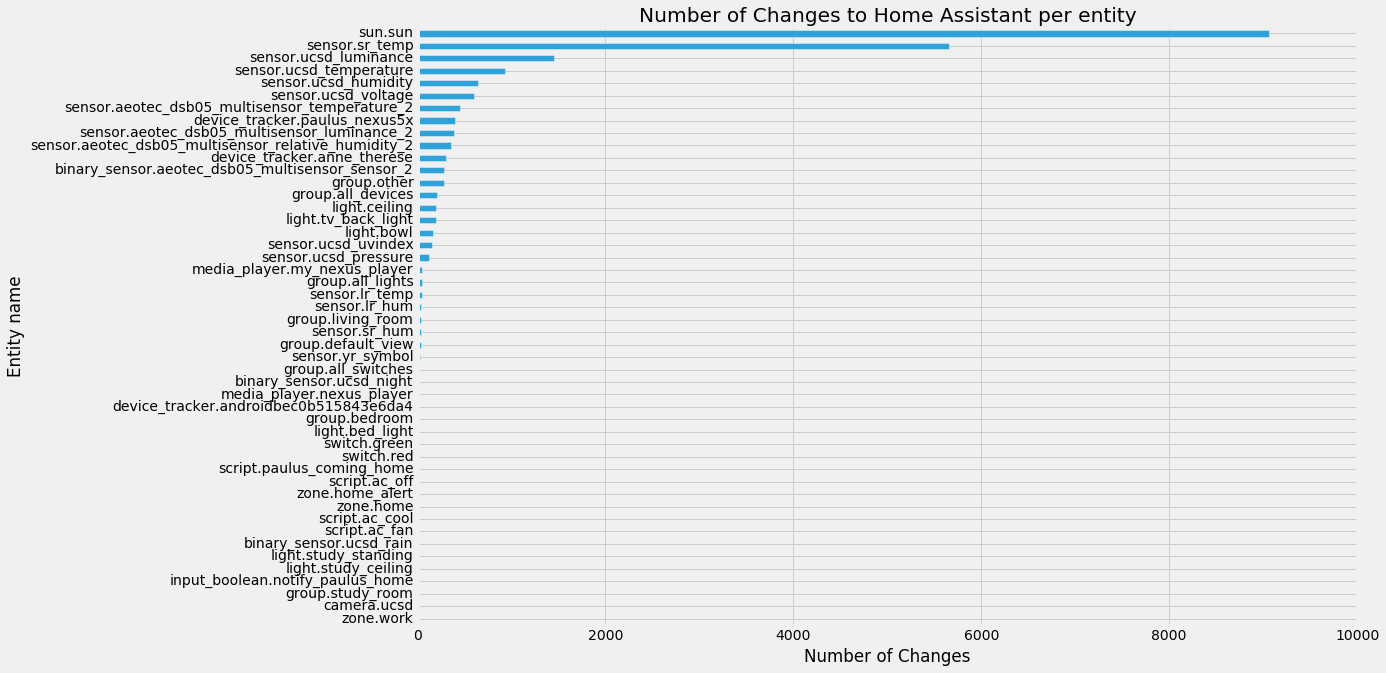

In [58]:
# executing our SQL query against the database and storing the output
entityquery = engine.execute("SELECT entity_id, COUNT(*) FROM states \
GROUP BY entity_id ORDER by 2 DESC")

# fetching th equery reults and reading it into a DataFrame
entitycallsDF = pd.DataFrame(entityquery.fetchall())

# naming the dataframe columns
entitycallsDF.columns = ['entity', 'Number of Changes']

# setting the entity name as an index of a new dataframe and sorting it \
# by the Number of Changes
ordered_indexed_df = entitycallsDF.set_index(['entity']).\
    sort_values(by='Number of Changes')

# displaying the data as a horizontal bar plot with a title and no legend
changesplot = ordered_indexed_df.plot(kind='barh', title='Number of Changes \
to Home Assistant per entity', figsize=(15, 10), legend=False)

# specifying labels for the X and Y axes
changesplot.set_xlabel('Number of Changes')
changesplot.set_ylabel('Entity name')

### How about plotting the status changes by day for every entity? 

['°C' '%' 'lux' 'cd/m²' 'mV' 'inHg' nan]


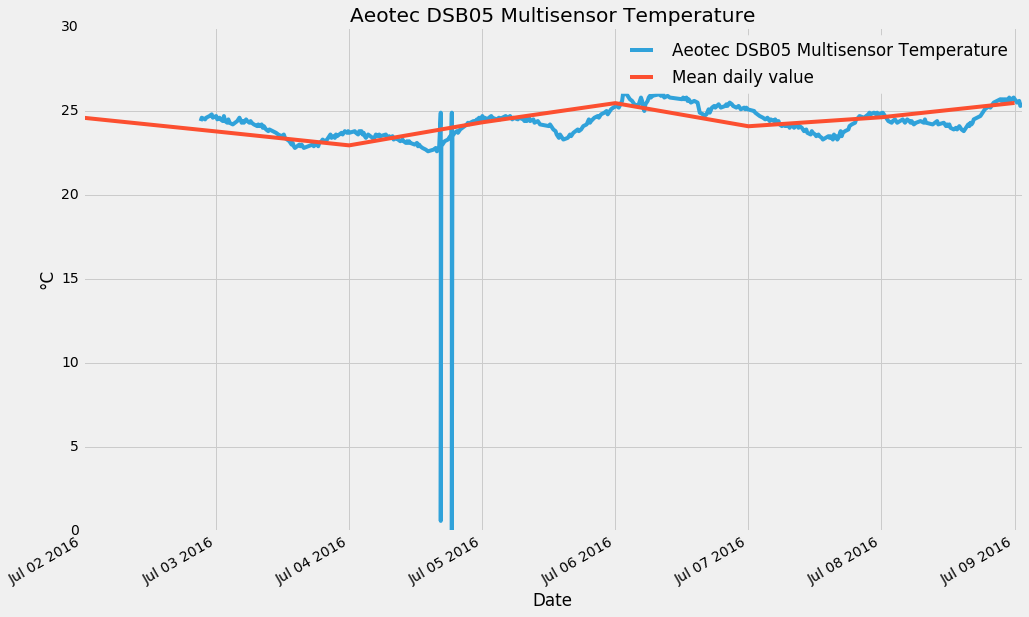

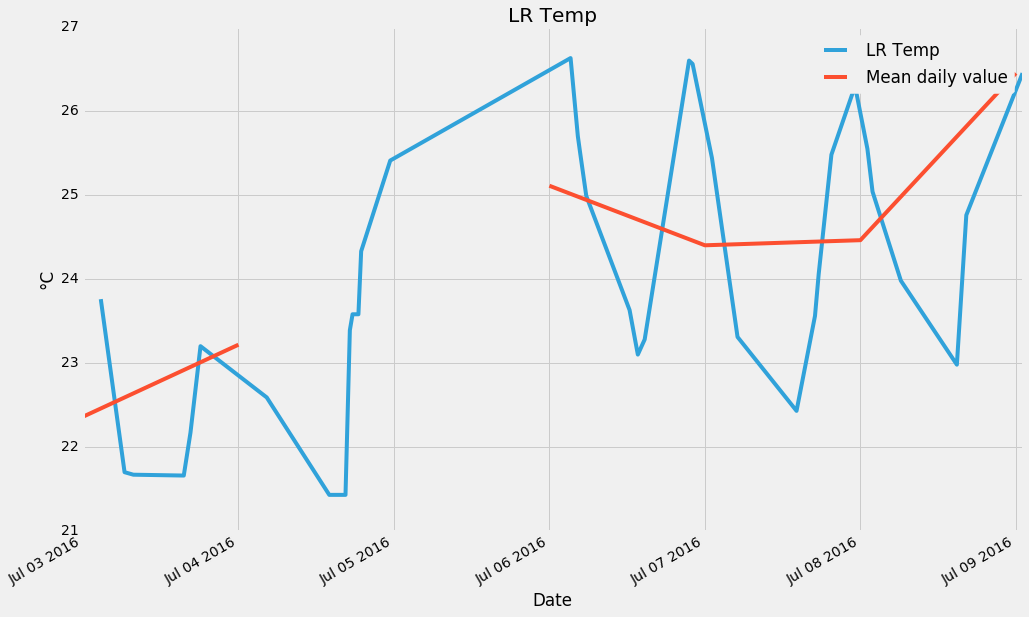

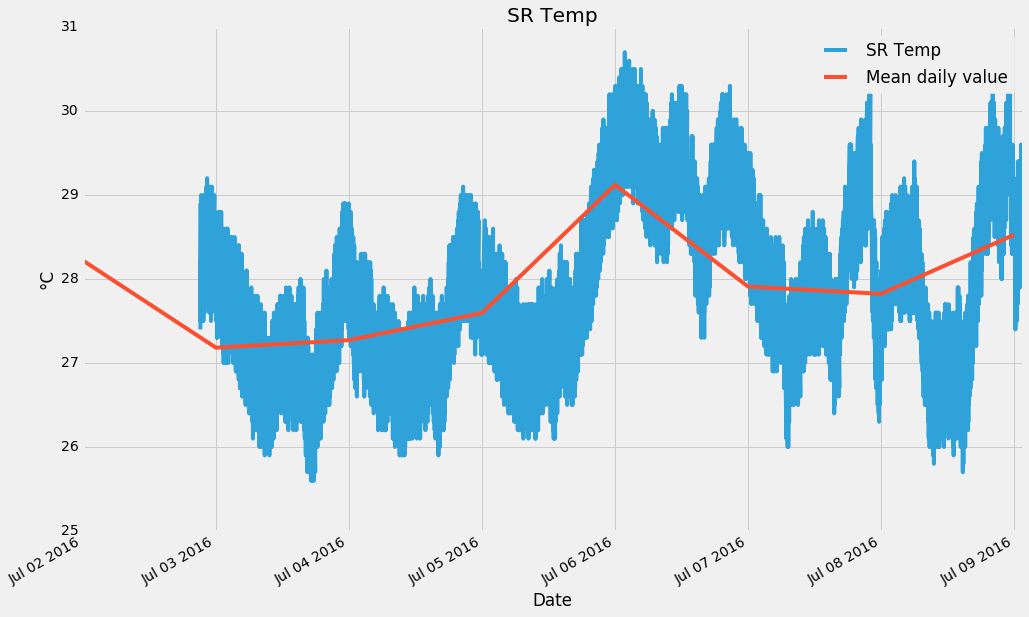

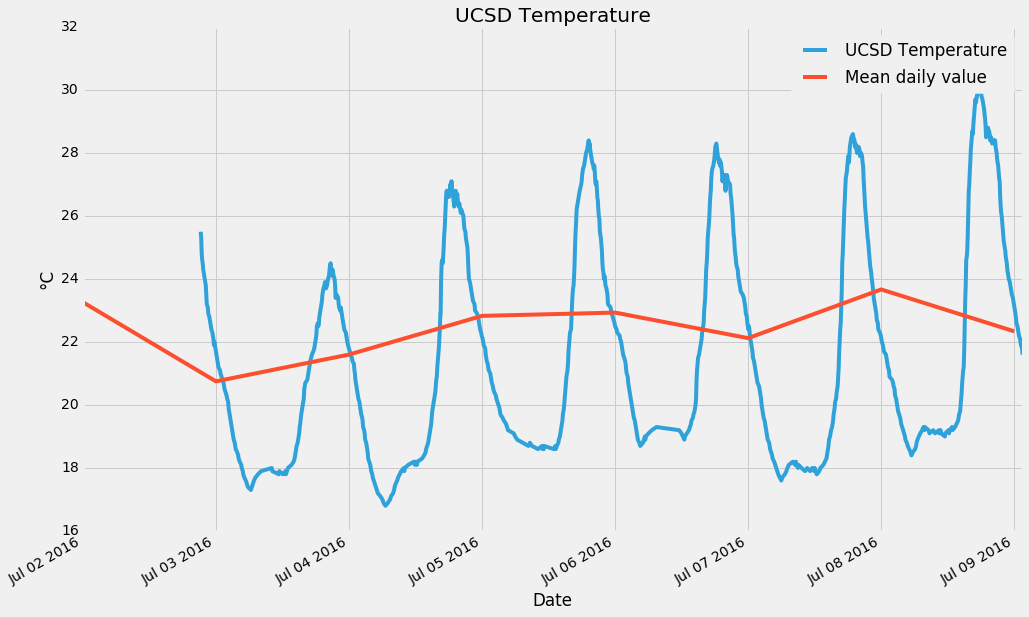

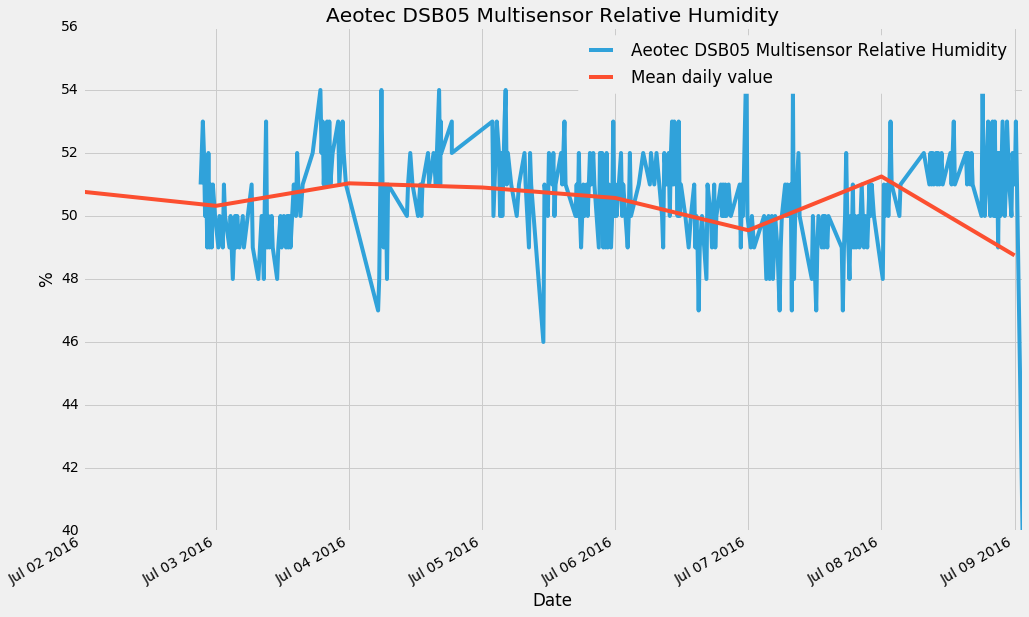

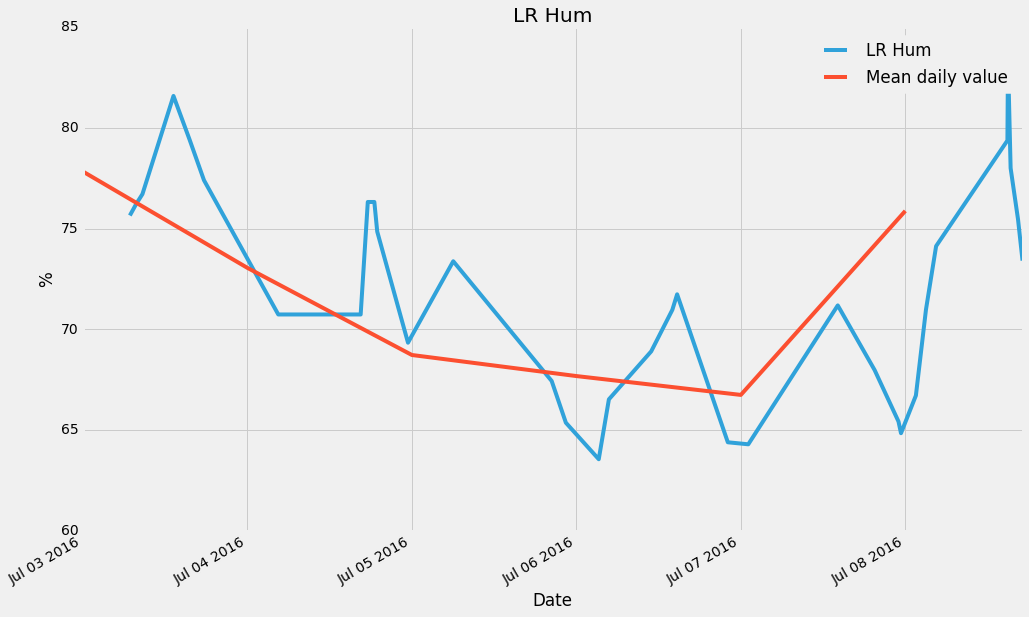

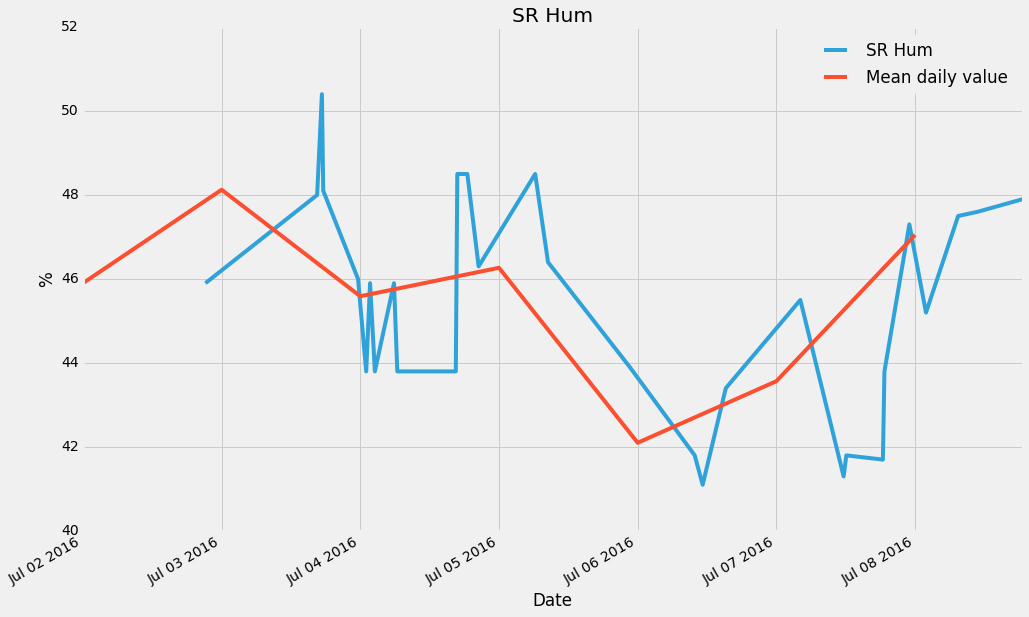

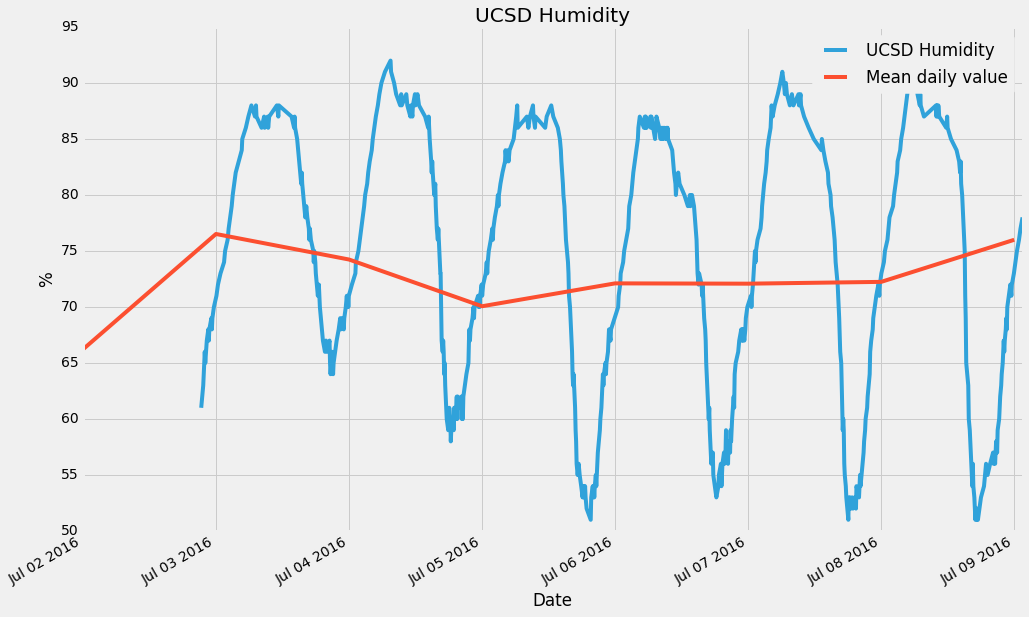

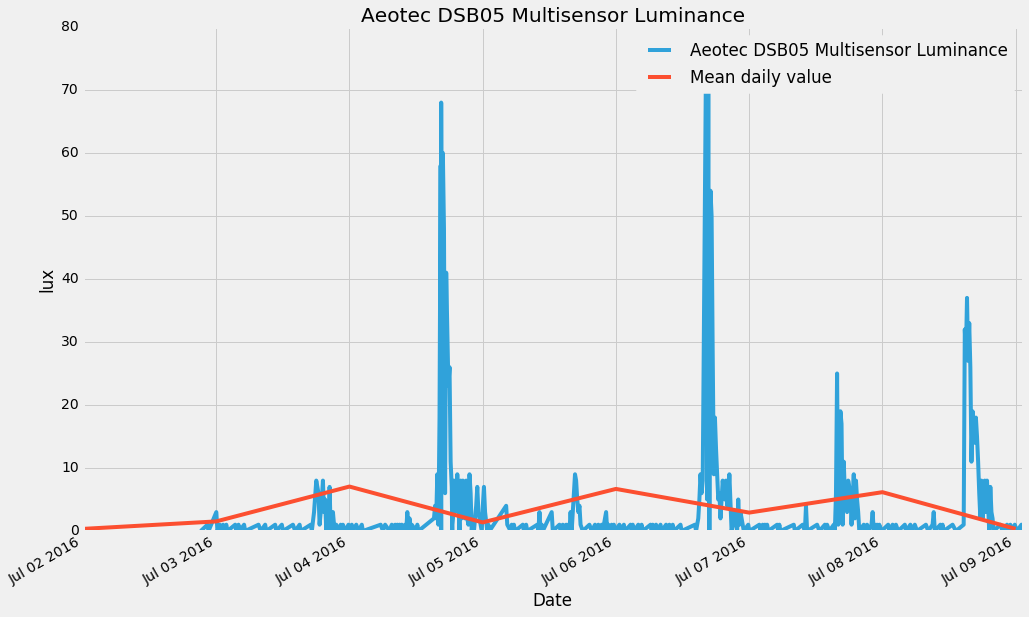

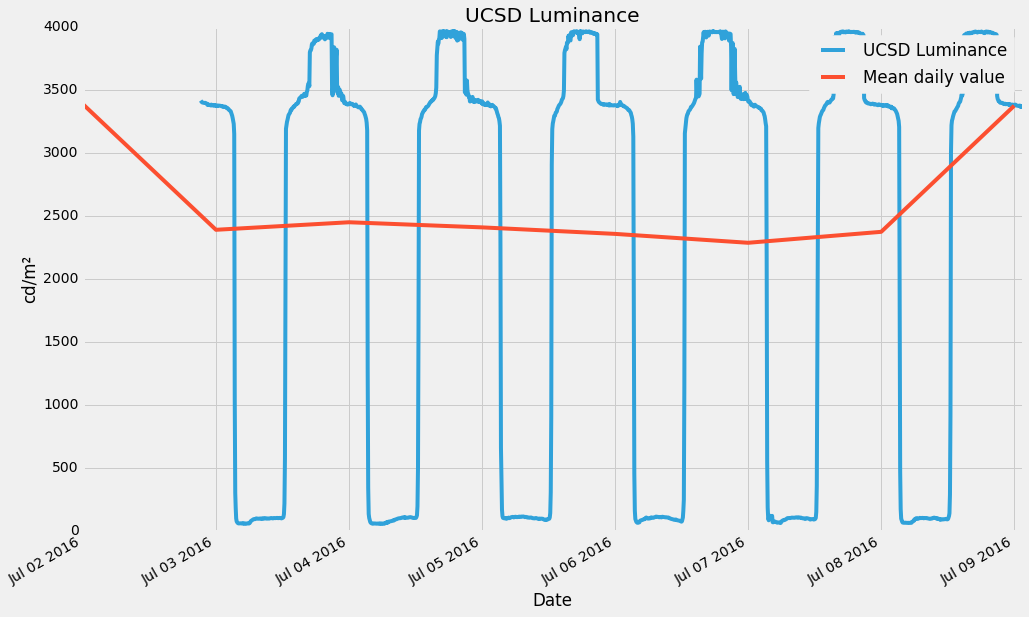

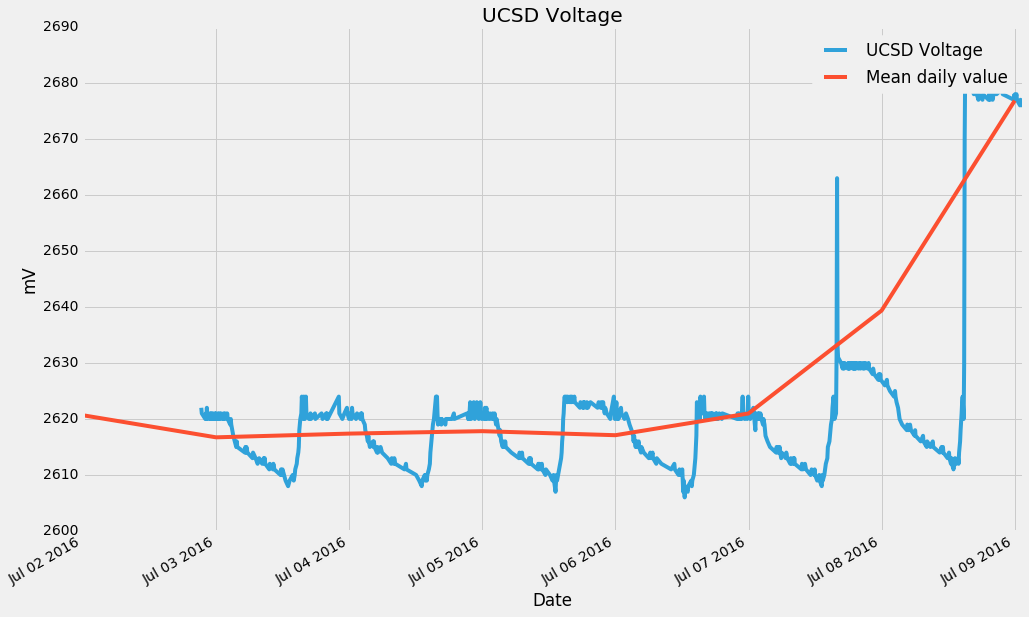

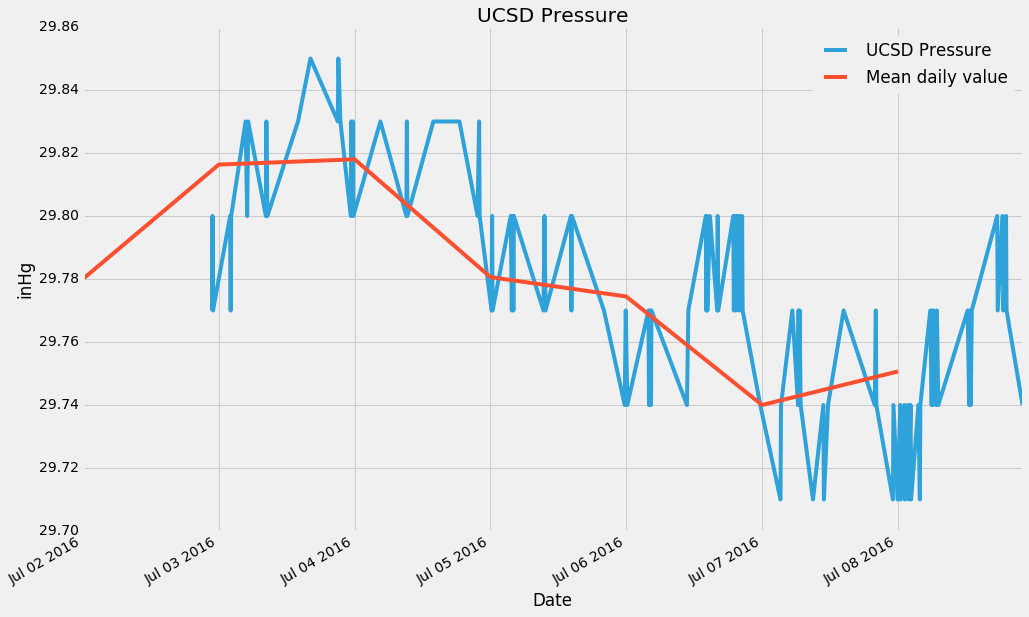

In [63]:
# query to pull all rows form the states table where last_changed field is on \
# or after the date_filter value
stmt = text("SELECT * FROM states where last_changed>=:date_filter")

# bind parameters to the stmt value, specifying the date_filter to be 10 days \
# before today
stmt = stmt.bindparams(date_filter=datetime.now()-timedelta(days=20))

# execute the SQL statement
allquery = engine.execute(stmt)

# get rows from query into a pandas dataframe
allqueryDF = pd.DataFrame(allquery.fetchall())

# name the dataframe rows for usability
allqueryDF.columns = ['state_id', 'domain', 'entity_id', 'state', 'attributes',
                      'origin', 'event_id', 'last_changed', 'last_updated',
                      'created']

# split the json from the 'attributes' column and 'concat' to existing \
# dataframe as separate columns
allqueryDF = pd.concat([allqueryDF, allqueryDF['attributes'].apply(json.loads)
                       .apply(pd.Series)], axis=1)

# change the last_changed datatype to datetime
allqueryDF['last_changed'] = pd.to_datetime(allqueryDF['last_changed'])

# let's see what units of measurement there are in our database and now in \
# our dataframe
print(allqueryDF['unit_of_measurement'].unique())

# let's chart data for each of the unique units of measurement
for i in allqueryDF['unit_of_measurement'].unique():
    # filter down our original dataset to only contain the unique unit of \
    # measurement, and removing the unknown values

    # Create variable with TRUE if unit of measurement is the one being \
    # processed now
    iunit = allqueryDF['unit_of_measurement'] == i

    # Create variable with TRUE if age is state is not unknown
    notunknown = allqueryDF['state'] != 'unknown'

    # Select all rows satisfying the requirement: unit_of_measurement \
    # matching the current unit and not having an 'unknown' status
    cdf = allqueryDF[iunit & notunknown].copy()

    # convert the last_changed 'object' to 'datetime' and use it as the index \
    # of our new concatenated dataframe
    cdf.index = cdf['last_changed']

    # convert the 'state' column to a float
    cdf['state'] = cdf['state'].astype(float)

    # create a groupby object for each of the friendly_name values
    groupbyName = cdf.groupby(['friendly_name'])

    # build a separate chart for each of the friendly_name values
    for key, group in groupbyName:

        # since we will be plotting the 'State' column, let's rename it to \
        # match the groupby key (distinct friendly_name value)
        tempgroup = group.copy()
        tempgroup.rename(columns={'state': key}, inplace=True)

        # plot the values, specify the figure size and title
        ax = tempgroup[[key]].plot(title=key, legend=False, figsize=(15, 10))

        # create a mini-dataframe for each of the groups
        df = groupbyName.get_group(key)

        # resample the mini-dataframe on the index for each Day, get the mean \
        # and plot it
        bx = df['state'].resample('D').mean().plot(label='Mean daily value',
                                                   legend=False)

        # set the axis labels and display the legend
        ax.set_ylabel(i)
        ax.set_xlabel('Date')
        ax.legend()